In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
#np.random.seed(10)
from IPython import display
import time
import imageio
import importlib

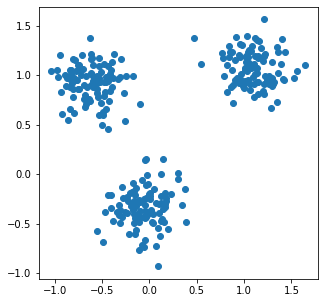

In [8]:
# Step 1: Generate 3 Gaussians with the given centers & covariances 
def gen_distribution(means, covs, points_per_gauss):
    """ Generate 3 Gaussian distributions"""
    x0 = np.random.multivariate_normal(mean = means[0], cov = covs[0], size = points_per_gauss)
    x1 = np.random.multivariate_normal(mean = means[1], cov = covs[1], size = points_per_gauss)
    x2 = np.random.multivariate_normal(mean = means[2], cov = covs[2], size = points_per_gauss)
    
    y0 = []
    y1 = []
    y2 = []
    for i in range(0,points_per_gauss):
        y0.append([0])
        y1.append([1])
        y2.append([2])
        
    X = np.vstack([x0, x1, x2])
    c = np.vstack([y0, y1, y2])

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    c = c[indices]
    return X, c

np.random.seed(10)
means = [[-0.0985, -0.3379], [-0.6325, 0.9322], [1.1078, 1.0856]]
covs = [[[0.04, 0], [0, 0.04]], [[0.04, 0], [0, 0.04]], [[0.04, 0], [0, 0.04]]]
points_per_gaussian = 100
X, c = gen_distribution(means, covs, points_per_gaussian)

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1])
plt.show()

In [9]:
class OnlineSNMF():
    def __init__(self, X, ydim, lamda=0.6, iterations=100):
        self.W = np.zeros((ydim, X.shape[1]))
        self.M = np.zeros((ydim, ydim))
        self.T = X.shape[0]
        self.X = X
        self.ydim = ydim
        self.iterations = iterations
        self.active_set = []
        self.ith_degree_used = np.zeros(ydim)
        self.lamda = lamda
        
        self.Y_store = np.zeros((self.ydim, self.T))
        self.X_store = X.T
        self.costs = []
        self.fname_list = []
        
    def adjust_weights(self, x_t, y_t, index, lamda = 0.6):
        """ Implement equation 5 """
        #print("Using equation 5")
        x_squared_norm = np.linalg.norm(x_t)**2
        y_squared = y_t * y_t
        #print(y_t.shape)

        test_condition = (x_squared_norm - np.sum(y_squared) + y_squared[index])

        if((test_condition ** 2) <= lamda):
            return 0
        else:
            if(test_condition < 0):
                return 0
            else:
                return np.sqrt(test_condition)
                   
    def update_weights(self, W, M, x_t, y_t, y_hat):
        """ Implement equation 8 """
        #y_hat += (y_t * y_t)
        #print("Using equation 8")
        y_dim = y_t.shape[0]

        x_t = x_t[np.newaxis, :]
        y_t = y_t[:, np.newaxis]

        dW = y_t @ (x_t - (self.W.T @ y_t).T)


        for i in range(self.ydim):
            if(y_hat[i] !=0):
                self.W[i] = self.W[i] + dW[i] / y_hat[i]

        dM = y_t @ (y_t.T - (self.M @ y_t).T)
        for i in range(self.M.shape[0]):
            dM[i][i] = 0

        for i in range(self.ydim):
            if(y_hat[i] !=0):
                self.M[i] = self.M[i] + dM[i] / y_hat[i]
        
    def fit_transform(self, plotting=False):
        y_hat = np.zeros(self.ydim)
        clusters = []
        
        for t in range(self.T): 
            x_t = self.X[t] 
            y_t = np.zeros(self.ydim) 
            #One-hot encoded (sort of - soft encoding not binary) 
            #  element Yt,i is non-zero if sample t is attributed to cluster i. --Quote from paper
            #Should scaling factor from eqn 3 be included? 
            for i in self.active_set:
                #Iterate till convergence -- convergence criteria not mentioned in paper for this algorithm
                #Ref. Code takes it as 100 steps? 
                for itr in range(self.iterations): 
                    y_ti = max(0, (self.W[i] @ x_t - self.M[i] @ y_t))
                y_t[i] = y_ti     
                
            for j in range(self.ydim):
                #Check all degrees of freedom
                #So far, this degree of freedom has not been used, then adjust weights by eqn 5;
                if(self.ith_degree_used[j] == 0):  
                    y_t[j] = self.adjust_weights(x_t, y_t, j, lamda=self.lamda)
                if(y_t[j]!=0):
                    self.ith_degree_used[j] = self.ith_degree_used[j] + 1
                if(j not in self.active_set and self.ith_degree_used[j] > 0):
                    self.active_set.append(j)
                
            # Compute cluster
            y_hat = y_hat + y_t * y_t
            self.Y_store[:, t] = y_t
            self.update_weights(self.W, self.M, x_t, y_t, y_hat)
            cluster = np.argmax(y_t)
            clusters.append(cluster)
            
            # Skip T = 0 since 0 cost
#             if t == 0:
#                 continue
        
            # Compute cost function
            YT = self.Y_store[:, 1:t+1]
            XT = self.X_store[:, 1:t+1]
            cost = np.linalg.norm(XT.T @ XT - YT.T @ YT, ord='fro') ** 2
            self.costs.append(cost)
        
            # Informative plotting/cool visualizations
            if plotting:
                if t % 10 == 0:
                    plt.figure(figsize=(5, 5))
                    plt.scatter(X[0:t+1, 0], X[0:t+1, 1], c=clusters)
                    plt.ylim([-2, 2])
                    plt.xlim([-2, 2])
                    plt.savefig('test/' + str(t) + '.png')
                    self.fname_list.append('test/' + str(t) + '.png')
                    plt.close()
        
        if plotting:
            with imageio.get_writer('test.gif', mode='I') as writer:
                for filename in self.fname_list:
                    image = imageio.imread(filename)
                    writer.append_data(image)
                
        return clusters

# Single plot for many trials of a single Gaussian experiment

In [10]:
reps = 50
means = [[-0.0985, -0.3379], [-0.6325, 0.9322], [1.1078, 1.0856]]
covs = [[[0.04, 0], [0, 0.04]], [[0.04, 0], [0, 0.04]], [[0.04, 0], [0, 0.04]]]
points_per_gaussian = 100
cost_store = []

np.random.seed(10)
for rep in range(reps):
    X, c = gen_distribution(means, covs, points_per_gaussian)
    
    model = OnlineSNMF(X, 3, lamda=0.6)
    clusters = model.fit_transform()
    cost_store.append(model.costs)

snmf_median = np.median(np.array(cost_store), axis=0)

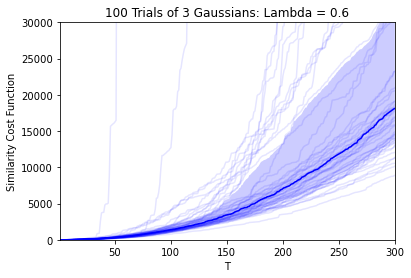

In [13]:
ts = np.arange(1, model.T + 1, 1)
snmf_25_quantile = np.quantile(cost_store, .25, axis=0)
snmf_75_quantile = np.quantile(cost_store, .75, axis=0)

plt.figure()
plt.plot(ts, snmf_median, c='b')
for i in range(len(cost_store)):
    plt.plot(ts, cost_store[i], alpha=0.1, c='b')
plt.fill_between(ts, snmf_25_quantile, snmf_75_quantile, facecolor='b', alpha=0.2)

plt.ylim([0, 30000])
plt.xlim([ts[0], ts[-1]])
plt.title('100 Trials of 3 Gaussians: Lambda = 0.6')
plt.xlabel('T')
plt.ylabel('Similarity Cost Function')
plt.savefig('plots/gaussian_trials_exp.pdf')